In [10]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import warnings
from dataclasses import dataclass, field
from typing import List, Tuple, Dict
from scipy.optimize import brentq
import time
from datetime import datetime, timezone
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('..')

from src.utils import export_trade_logs
from src.visualization import plot_results

warnings.filterwarnings('ignore')

# Avellaneda-Stoikov Market-Making Engine

Pure martingale baseline, no directional signal.

The mid-price follows a Brownian motion with zero drift: 

$$ dS_t = σ dW_t $$

The market maker optimises bid/ask quotes to maximise
expected terminal wealth subject to inventory risk.

This notebook serves as the theoretical benchmark:
any alpha-augmented model must outperform this baseline.

## 1. Basic implementation of the model, test and visualisation

In [11]:
class AvellanedaStoikovMarketMaker:
    """
    Closed-form AS market maker on a single simulated price path.

    Used for visual sanity checks before running on real data.
    Parameters follow the original Avellaneda & Stoikov (2008) notation.
    """

    def __init__(self,
                 sigma: float,        # Price volatility (σ)
                 kappa: float,        # Client price sensitivity (κ)
                 gamma: float,        # Inventory risk aversion (γ)
                 A: float,            # Base arrival intensity
                 T: float,            # Time horizon
                 Q: int   = 10,       # Maximum inventory bound |q| ≤ Q
                 alpha: float = 0.01  # Terminal inventory penalty α·q²
                ):
        self.sigma = sigma
        self.kappa = kappa
        self.gamma = gamma
        self.A     = A
        self.T     = T
        self.Q     = Q
        self.alpha = alpha

        self.inventory = 0
        self.cash      = 0.0
        self.mid_price = None

        self.time_history      = []
        self.price_history     = []
        self.inventory_history = []
        self.bid_history       = []
        self.ask_history       = []
        self.pnl_history       = []

    def reservation_price(self, mid_price: float, t: float) -> float:
        """
        r = S - q·γ·σ²·(T-t)

        Shifts the fair price toward reducing inventory:
          q > 0 (long)  → r < S : willing to sell cheaper
          q < 0 (short) → r > S : willing to buy higher
        """
        return mid_price - self.inventory * self.gamma * self.sigma**2 * (self.T - t)

    def optimal_spread_half(self, t: float) -> float:
        """
        Half of the optimal symmetric spread ψ*/2.
        Combines time-decay and stationary components.
        """
        term1 = self.gamma * self.sigma**2 * (self.T - t)
        term2 = (2.0 / self.gamma) * math.log(1.0 + self.gamma / self.kappa)
        return (term1 + term2) / 2.0

    def get_quotes(self, mid_price: float, t: float) -> tuple:
        """
        Returns (bid, ask, delta_bid, delta_ask).
        Deltas are distances from mid — used to compute fill intensities.
        """
        r    = self.reservation_price(mid_price, t)
        half = self.optimal_spread_half(t)

        bid = r - half
        ask = r + half

        delta_bid = mid_price - bid
        delta_ask = ask - mid_price

        return bid, ask, delta_bid, delta_ask

    def arrival_intensity(self, delta: float) -> float:
        """λ(δ) = A · exp(-κ·δ)"""
        if delta < 0:
            return self.A  # aggressive quote: maximum intensity
        return self.A * math.exp(-self.kappa * delta)

    def simulate_step(self, mid_price: float, t: float, dt: float) -> float:
        """
        Simulates one time step dt.
        Fills are drawn via a Poisson approximation.
        Returns the new mid-price after Brownian diffusion.
        """
        bid, ask, delta_bid, delta_ask = self.get_quotes(mid_price, t)

        lam_b = self.arrival_intensity(delta_bid) if self.inventory <  self.Q else 0.0
        lam_a = self.arrival_intensity(delta_ask) if self.inventory > -self.Q else 0.0

        p_buy  = lam_b * dt
        p_sell = lam_a * dt

        # Single draw to avoid simultaneous fills
        u = random.random()
        if u < p_buy:
            self.inventory += 1
            self.cash      -= bid
        elif u < p_buy + p_sell:
            self.inventory -= 1
            self.cash      += ask

        # Brownian diffusion
        new_mid = mid_price + self.sigma * math.sqrt(dt) * random.gauss(0, 1)

        self.time_history.append(t)
        self.price_history.append(mid_price)
        self.inventory_history.append(self.inventory)
        self.bid_history.append(bid)
        self.ask_history.append(ask)
        self.pnl_history.append(self.pnl(mid_price))

        return new_mid

    def terminal_pnl(self) -> float:
        """Final P&L including penalty α·q² on residual inventory."""
        last_price = self.price_history[-1] if self.price_history else 0.0
        return self.cash + self.inventory * last_price - self.alpha * self.inventory**2

    def pnl(self, current_price: float) -> float:
        """Mark-to-market P&L (no terminal penalty)."""
        return self.cash + self.inventory * current_price


def run_simulation(mm: AvellanedaStoikovMarketMaker,
                   S0: float = 100.0,
                   n_steps: int = 1000) -> dict:
    """Main simulation loop over n_steps time steps."""
    dt  = mm.T / n_steps
    mid = S0

    for i in range(n_steps):
        t   = i * dt
        mid = mm.simulate_step(mid, t, dt)

    return {
        "terminal_pnl":    mm.terminal_pnl(),
        "final_inventory": mm.inventory,
        "n_trades": sum(
            1 for i in range(1, len(mm.inventory_history))
            if mm.inventory_history[i] != mm.inventory_history[i-1]
        )
    }

Terminal P&L    : 71.35
Final inventory : 2
Total trades    : 114


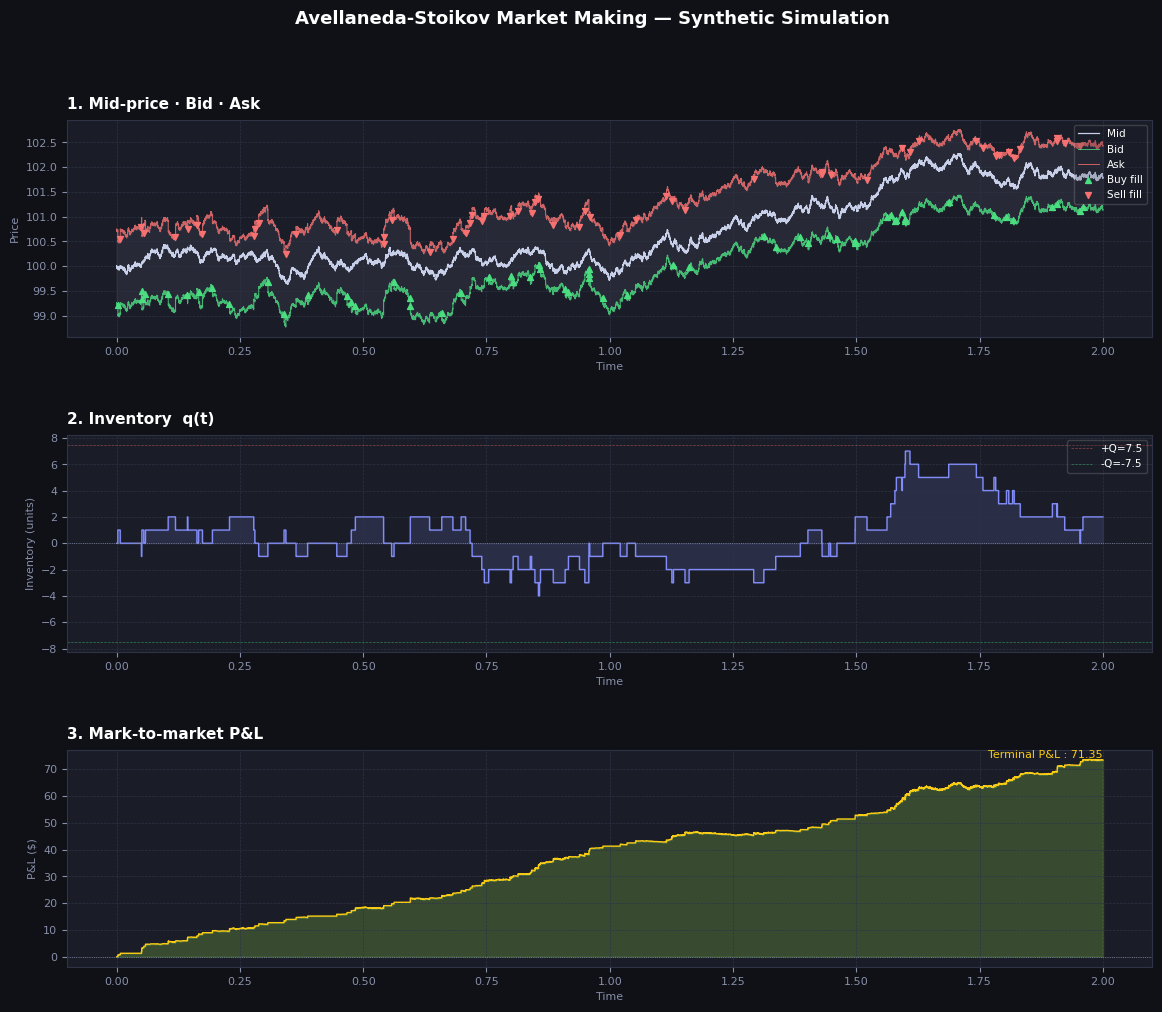

In [12]:
# ─────────────────────────────────────────────
#  SIMULATION
# ─────────────────────────────────────────────

random.seed(42)

mm = AvellanedaStoikovMarketMaker(
    sigma = 1.0,    # moderate volatility
    kappa = 1.5,    # client price sensitivity
    gamma = 0.1,    # moderate risk aversion
    A     = 100.0,  # high base liquidity
    T     = 2.0,
    Q     = 7.5,
    alpha = 0.5
)

stats = run_simulation(mm, S0=100.0, n_steps=50000)

print(f"Terminal P&L    : {stats['terminal_pnl']:.2f}")
print(f"Final inventory : {stats['final_inventory']}")
print(f"Total trades    : {stats['n_trades']}")


# ─────────────────────────────────────────────
#  VISUALISATION  (3 panneaux)
# ─────────────────────────────────────────────

t   = mm.time_history
mid = mm.price_history
bid = mm.bid_history
ask = mm.ask_history
inv = mm.inventory_history
pnl = mm.pnl_history

trade_idx = [i for i in range(1, len(inv)) if inv[i] != inv[i-1]]
buy_idx   = [i for i in trade_idx if inv[i] > inv[i-1]]
sell_idx  = [i for i in trade_idx if inv[i] < inv[i-1]]

fig = plt.figure(figsize=(14, 11))
fig.patch.set_facecolor("#0f1117")
gs  = gridspec.GridSpec(3, 1, hspace=0.45)

DARK_BG  = "#0f1117"; PANEL_BG = "#1a1d27"
MID_COL  = "#c8cfe8"; BID_COL  = "#4ade80"
ASK_COL  = "#f87171"; INV_COL  = "#818cf8"
PNL_COL  = "#facc15"

def style_ax(ax, title):
    ax.set_facecolor(PANEL_BG)
    ax.set_title(title, color="white", fontsize=11, pad=8,
                 loc="left", fontweight="bold")
    ax.tick_params(colors="#8890aa", labelsize=8)
    for spine in ax.spines.values():
        spine.set_edgecolor("#2e3347")
    ax.grid(True, color="#2e3347", linewidth=0.5, linestyle="--")
    ax.set_xlabel("Time", color="#8890aa", fontsize=8)

# Panel 1 — Mid-price, bid, ask, and fills
ax1 = fig.add_subplot(gs[0])
style_ax(ax1, "1. Mid-price · Bid · Ask")
ax1.plot(t, mid, color=MID_COL, linewidth=0.9, label="Mid", zorder=3)
ax1.plot(t, bid, color=BID_COL, linewidth=0.7, alpha=0.8, label="Bid", zorder=2)
ax1.plot(t, ask, color=ASK_COL, linewidth=0.7, alpha=0.8, label="Ask", zorder=2)
ax1.fill_between(t, bid, ask, alpha=0.08, color=MID_COL)
if buy_idx:
    ax1.scatter([t[i] for i in buy_idx], [bid[i] for i in buy_idx],
                color=BID_COL, s=18, zorder=5, marker="^", label="Buy fill")
if sell_idx:
    ax1.scatter([t[i] for i in sell_idx], [ask[i] for i in sell_idx],
                color=ASK_COL, s=18, zorder=5, marker="v", label="Sell fill")
ax1.set_ylabel("Price", color="#8890aa", fontsize=8)
ax1.legend(loc="upper right", fontsize=7.5, framealpha=0.2,
           labelcolor="white", facecolor=PANEL_BG)

# Panel 2 — Inventory path
ax2 = fig.add_subplot(gs[1])
style_ax(ax2, "2. Inventory  q(t)")
ax2.step(t, inv, color=INV_COL, linewidth=1.0, where="post")
ax2.fill_between(t, inv, step="post", alpha=0.15, color=INV_COL)
ax2.axhline(0,      color="#8890aa", linewidth=0.6, linestyle=":")
ax2.axhline( mm.Q,  color=ASK_COL,  linewidth=0.5, linestyle="--",
             alpha=0.5, label=f"+Q={mm.Q}")
ax2.axhline(-mm.Q,  color=BID_COL,  linewidth=0.5, linestyle="--",
             alpha=0.5, label=f"-Q={-mm.Q}")
ax2.set_ylabel("Inventory (units)", color="#8890aa", fontsize=8)
ax2.legend(loc="upper right", fontsize=7.5, framealpha=0.2,
           labelcolor="white", facecolor=PANEL_BG)

# Panel 3 — Mark-to-market P&L
ax3 = fig.add_subplot(gs[2])
style_ax(ax3, "3. Mark-to-market P&L")
pnl_arr = np.array(pnl)
ax3.plot(t, pnl_arr, color=PNL_COL, linewidth=1.0)
ax3.fill_between(t, pnl_arr, alpha=0.12, color=PNL_COL)
ax3.axhline(0, color="#8890aa", linewidth=0.6, linestyle=":")
ax3.fill_between(t, pnl_arr, 0, where=(pnl_arr >= 0),
                 alpha=0.15, color=BID_COL)
ax3.fill_between(t, pnl_arr, 0, where=(pnl_arr <  0),
                 alpha=0.15, color=ASK_COL)
ax3.set_ylabel("P&L ($)", color="#8890aa", fontsize=8)
ax3.annotate(f"  Terminal P&L : {stats['terminal_pnl']:.2f}",
             xy=(t[-1], pnl[-1]), color=PNL_COL, fontsize=8,
             ha="right", va="bottom")

plt.suptitle("Avellaneda-Stoikov Market Making — Synthetic Simulation",
             color="white", fontsize=13, fontweight="bold", y=0.98)
plt.show()

## 2. Backtest on real BTC/USDT 1-second data

The AS model is our theoretical benchmark.
Under the pure martingale assumption (zero drift),
the market maker earns the spread but suffers from adverse selection and inventory risk.

Expected result: gross P&L ≈ 0, net P&L < 0 after frictions.
This confirms that a directional signal is necessary to survive realistic transaction costs.

In [13]:
"""
╔══════════════════════════════════════════════════════════════════╗
║       Avellaneda-Stoikov Market Making Engine                    ║
║       Calibré sur données-1s BTC (Oct-Dec 2025)                  ║
║                                                                  ║
║  Architecture :                                                  ║
║    - EngineParams     : paramètres du moteur AS                  ║
║    - FrictionParams   : coûts de transaction réalistes           ║
║    - ASEngine         : calcul des quotes bid/ask optimales      ║
║    - SessionState     : gestion inventaire + cash                ║
║    - run_backtest()   : boucle de simulation complète            ║
║    - run_corrected()  : split IS/OOS + comparaison frictions     ║
║                                                                  ║
║  Frictions modélisées :                                          ║
║    - Commission Binance  : $0.02 per share                       ║
║    - Slippage            : bruit gaussien calibré sur latence    ║
║                           intra-bougie U[5s, 30s]                ║
║    - Adverse selection : pénalité sur move forward k bougies     ║
║                                                                  ║
║  Split temporel :                                                ║
║    - In-Sample  : Jul-Nov  (calibration κ, A)                    ║
║    - Out-Sample : Dec  (test strict)                             ║
╚══════════════════════════════════════════════════════════════════╝

"""

'\n╔══════════════════════════════════════════════════════════════════╗\n║       Avellaneda-Stoikov Market Making Engine                    ║\n║       Calibré sur données-1s BTC (Oct-Dec 2025)                  ║\n║                                                                  ║\n║  Architecture :                                                  ║\n║    - EngineParams     : paramètres du moteur AS                  ║\n║    - FrictionParams   : coûts de transaction réalistes           ║\n║    - ASEngine         : calcul des quotes bid/ask optimales      ║\n║    - SessionState     : gestion inventaire + cash                ║\n║    - run_backtest()   : boucle de simulation complète            ║\n║    - run_corrected()  : split IS/OOS + comparaison frictions     ║\n║                                                                  ║\n║  Frictions modélisées :                                          ║\n║    - Commission Binance  : $0.02 per share                       ║\n║    - Slippage  

In [14]:
# ══════════════════════════════════════════════════════════════════
#                          CONFIGURATION
# ══════════════════════════════════════════════════════════════════

DATA_PATH  = 'btc_1s_Jul-Dec_2025.parquet'
ticker     = 'BTCUSDT'
model      = 'AS Engine (Pure martingale)'
IS_MONTHS  = [7, 8, 9, 10, 11]   # training period
OOS_MONTHS = [12]                 # test period — strictly unseen
RANDOM_SEED = 42


# ══════════════════════════════════════════════════════════════════
#                           PARAMETERS
# ══════════════════════════════════════════════════════════════════

@dataclass
class EngineParams:
    """
    Avellaneda-Stoikov engine parameters.

    gamma, kappa, A have no defaults — must be set via calibrate().
    This prevents silently running with parameters from another asset.

    Calibrated from IS data:
        gamma : inventory risk aversion (CARA utility)
        kappa : client price sensitivity — calibrated on tick size
        A     : base fill intensity — calibrated for 50% fill prob

    Structural (asset/strategy-dependent):
        Q            : maximum inventory bound |q| ≤ Q
        alpha_penalty: terminal penalty α·q² on residual inventory
        dt_decision  : re-quoting interval in seconds
        win_vol      : rolling volatility window (candles)
        T_session    : session duration in seconds (86400 = 24h crypto)
    """
    gamma:         float
    kappa:         float
    A:             float

    Q:             int   = 15
    alpha_penalty: float = 0.01
    dt_decision:   float = 15.0
    win_vol:       int   = 300
    T_session:     float = 86400.0


@dataclass
class FrictionParams:
    """
    Realistic execution frictions.

    lot_size             : trade size in BTC
    commission_per_share : Binance flat commission per lot
    lag_min/max_sec      : intra-candle execution lag U[min, max]
    dt_bougie_sec        : candle duration in seconds
    adv_sel_window       : forward window for adverse selection measure
    adv_sel_scale        : fraction of adverse move charged as cost
    """
    lot_size:             float = 0.1
    commission_per_share: float = 0.02
    lag_min_sec:          float = 0.05
    lag_max_sec:          float = 0.20
    dt_bougie_sec:        float = 60.0
    adv_sel_window:       int   = 2
    adv_sel_scale:        float = 0.1

    def commission(self) -> float:
        """Flat commission per trade."""
        return self.commission_per_share * self.lot_size

    def execution_noise(self, sigma_1min: float,
                        rng: np.random.Generator) -> float:
        """
        Price noise from intra-candle execution lag.
        σ_exec = σ_1min × √(lag / candle_duration)
        lag ~ U[lag_min, lag_max] seconds
        """
        lag_sec    = rng.uniform(self.lag_min_sec, self.lag_max_sec)
        sigma_exec = sigma_1min * math.sqrt(lag_sec / self.dt_bougie_sec)
        return float(rng.normal(0.0, sigma_exec))


In [15]:
def calibrate(df_is: pd.DataFrame,
              gamma: float = 0.01,
              fill_prob_target: float = 0.5,
              dt_decision: float = 15.0,
              Q: int = 15,
              alpha_penalty: float = 0.01,
              win_vol: int = 300,
              T_session: float = 86400.0) -> EngineParams:
    """
    Calibrates κ and A from IS data via method of moments.

    κ is solved from the stationary spread equation:
        ψ_∞ = (2/γ) · ln(1 + γ/κ) = tick_size / price_ref

    A is set to achieve fill_prob_target at the half-spread:
        fill_prob = A · exp(-κ · δ_ref) · dt_decision
    """
    price_ref   = df_is['close'].median()
    tick_size   = 0.10 if 'BTCUSDT' in ticker else 1.0
    spread_norm = tick_size / price_ref

    kappa = brentq(
        lambda k: (2.0 / gamma) * np.log(1.0 + gamma / k) - spread_norm,
        1e-6, 1e12
    )

    delta_ref = spread_norm / 2.0
    A = fill_prob_target / (np.exp(-kappa * delta_ref) * dt_decision)

    print(f'[calibrate] IS candles    : {len(df_is):,}')
    print(f'[calibrate] Median price  : {price_ref:,.2f}')
    print(f'[calibrate] Spread        : {spread_norm*10000:.2f} bps  '
          f'({spread_norm*price_ref:.4f} $)')
    print(f'[calibrate] κ             : {kappa:.4f}')
    print(f'[calibrate] A             : {A:.6f} fills/sec')
    print(f'[calibrate] γ             : {gamma}')
    print(f'[calibrate] Fill prob     : '
          f'{A * np.exp(-kappa*delta_ref) * dt_decision:.3f} at half-spread')

    return EngineParams(
        gamma=gamma, 
        kappa=kappa, 
        A=A,
        Q=Q, 
        alpha_penalty=alpha_penalty,
        dt_decision=dt_decision, 
        win_vol=win_vol, 
        T_session=T_session,
    )

In [16]:
# ══════════════════════════════════════════════════════════════════
#                           AS ENGINE
# ══════════════════════════════════════════════════════════════════

class ASEngine:
    """
    Optimal quote computation — Avellaneda-Stoikov (2008).
    No directional signal (α = 0): price is a pure martingale.

    Closed-form solution from Guéant, Lehalle & Fernandez-Tapia (2013):
        r(t,q)  = S_t - q·γ·σ²·(T-t)           reservation price
        ψ*(t)   = γ·σ²·(T-t) + (2/γ)·ln(1+γ/κ) optimal spread
        bid     = r - ψ*/2
        ask     = r + ψ*/2
    """

    def __init__(self, params: EngineParams):
        self.p = params

    def reservation_price(self, mid: float, q: int,
                          sigma: float, t_rem: float) -> float:
        """Inventory-adjusted fair value."""
        r_norm = 1.0 - q * self.p.gamma * sigma**2 * t_rem
        return mid * r_norm

    def spread_half(self, sigma: float, t_rem: float) -> float:
        """Half of the optimal spread, as a fraction of mid."""
        term_time = self.p.gamma * sigma**2 * t_rem
        term_stat = (2.0 / self.p.gamma) * math.log(
            1.0 + self.p.gamma / self.p.kappa
        )
        return (term_time + term_stat) / 2.0

    def get_quotes(self, mid: float, q: int,
                   sigma: float, t_rem: float
                   ) -> Tuple[float, float, float, float]:
        """
        Returns (bid, ask, delta_bid_norm, delta_ask_norm).
        Normalised deltas feed the Poisson intensity function.
        """
        r         = self.reservation_price(mid, q, sigma, t_rem)
        half_norm = self.spread_half(sigma, t_rem)
        bid = mid * (r/mid - half_norm)
        ask = mid * (r/mid + half_norm)
        return bid, ask, (mid - bid) / mid, (ask - mid) / mid

    def intensity(self, delta_norm: float) -> float:
        """λ(δ) = A · exp(-κ·δ_norm)"""
        return self.p.A if delta_norm <= 0 \
               else self.p.A * math.exp(-self.p.kappa * delta_norm)

In [17]:
# ══════════════════════════════════════════════════════════════════
#                       SESSION STATE
# ══════════════════════════════════════════════════════════════════

@dataclass
class Trade:
    """Record of a single fill."""
    side:           str
    decision_price: float
    fill_price:     float
    mid_at_fill:    float
    commission:     float
    slippage:       float
    adv_sel_cost:   float
    timestamp:      pd.Timestamp


@dataclass
class SessionState:
    """
    Market maker state within a single trading session.
    Fully reset at the start of each session — no overnight inventory.
    """
    inventory: int   = 0
    cash:      float = 0.0
    trades:    List  = field(default_factory=list)

    def buy(self, fill_price, commission, adv_cost, lot,
            ts, dec_price, mid, slippage):
        """Buy fill: debit cash by cost + frictions."""
        self.cash      -= fill_price * lot + commission + adv_cost
        self.inventory += 1
        self.trades.append(Trade('buy', dec_price, fill_price, mid,
                                 commission, abs(slippage)*lot, adv_cost, ts))

    def sell(self, fill_price, commission, adv_cost, lot,
             ts, dec_price, mid, slippage):
        """Sell fill: credit cash net of frictions."""
        self.cash      += fill_price * lot - commission - adv_cost
        self.inventory -= 1
        self.trades.append(Trade('sell', dec_price, fill_price, mid,
                                 commission, abs(slippage)*lot, adv_cost, ts))

    def mtm(self, price: float, lot: float) -> float:
        """Mark-to-market P&L."""
        return self.cash + self.inventory * price * lot

    def terminal(self, price: float, alpha_pen: float, lot: float) -> float:
        """Final P&L with terminal inventory penalty."""
        return self.cash + self.inventory * price * lot \
               - alpha_pen * self.inventory**2

In [18]:
# ══════════════════════════════════════════════════════════════════
# BLOC 5 — BACKTEST
# ══════════════════════════════════════════════════════════════════

def run_backtest(df: pd.DataFrame,
                 ep: EngineParams,
                 fp: FrictionParams,
                 label: str,
                 seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, pd.DataFrame]:
    """
    Full backtest over all sessions in the DataFrame.

    At each dt_decision interval:
      1. Compute rolling σ_t
      2. Compute optimal bid/ask via ASEngine
      3. Sample fills via Poisson approximation
      4. Apply frictions (slippage, commission, adverse selection)

    Returns: (records_df, sessions_df, stats_dict, trades_df)
    """
    engine = ASEngine(ep)
    rng    = np.random.default_rng(seed)

    df = df.copy()
    df['r_t']     = df['close'].pct_change()
    df['sigma_t'] = df['r_t'].rolling(ep.win_vol).std()
    df['sigma_t'] = df['sigma_t'].fillna(df['sigma_t'].median())
    df['date']    = df['timestamp'].dt.date

    records, session_pnls, all_trades = [], [], []
    step = max(1, int(ep.dt_decision))
    lot  = fp.lot_size

    for date, session in df.groupby('date'):
        session = session.reset_index(drop=True)
        n       = len(session)
        if n < ep.win_vol + step:
            continue

        state       = SessionState()
        sess_closes = session['close'].values

        for idx in range(ep.win_vol, n, step):
            row     = session.iloc[idx]
            mid     = float(row['close'])
            sigma_t = float(row['sigma_t'])
            ts      = row['timestamp']
            t_rem   = max(ep.T_session - idx, 1.0)

            bid, ask, db_norm, da_norm = engine.get_quotes(
                mid, state.inventory, sigma_t, t_rem
            )

            lam_b  = engine.intensity(db_norm) if state.inventory <  ep.Q else 0.0
            lam_a  = engine.intensity(da_norm) if state.inventory > -ep.Q else 0.0
            p_buy  = min(lam_b * ep.dt_decision, 1.0)
            p_sell = min(lam_a * ep.dt_decision, 1.0)

            u           = rng.random()
            filled_side = None
            if u < p_buy:
                filled_side    = 'buy'
                decision_price = bid
            elif u < p_buy + p_sell:
                filled_side    = 'sell'
                decision_price = ask

            if filled_side is not None:
                noise      = fp.execution_noise(sigma_t * mid, rng)
                fill_price = decision_price + noise
                slippage   = noise

                fut_idx  = min(idx + fp.adv_sel_window, len(sess_closes) - 1)
                fut_ret  = sess_closes[fut_idx] - mid
                adv_move = max(-fut_ret, 0.0) if filled_side == 'buy' \
                           else max(fut_ret, 0.0)
                adv_cost = fp.adv_sel_scale * adv_move * lot
                comm     = fp.commission()

                if filled_side == 'buy':
                    state.buy(fill_price, comm, adv_cost, lot,
                              ts, decision_price, mid, slippage)
                else:
                    state.sell(fill_price, comm, adv_cost, lot,
                               ts, decision_price, mid, slippage)

                all_trades.append({
                    'date': date, 'timestamp': ts, 'side': filled_side,
                    'decision_price':   round(decision_price, 4),
                    'fill_price':       round(fill_price, 4),
                    'slippage_$':       round(abs(slippage) * lot, 6),
                    'commission_$':     round(comm, 6),
                    'adv_sel_$':        round(adv_cost, 6),
                    'total_friction_$': round(abs(slippage)*lot + comm + adv_cost, 6),
                    'inventory_after':  state.inventory,
                    'mid':              round(mid, 4),
                    'bid':              round(bid, 4),
                    'ask':              round(ask, 4),
                    'spread_$':         round(ask - bid, 4),
                    'spread_bps':       round((ask - bid) / mid * 10000, 4),
                    'sigma_t':          round(sigma_t, 8),
                    't_rem_min':        round(t_rem, 1),
                    'fut_ret_$':        round(fut_ret, 4),
                })

            records.append({
                'timestamp': ts, 'mid': mid, 'bid': bid, 'ask': ask,
                'inventory': state.inventory, 'mtm_pnl': state.mtm(mid, lot),
                'sigma_t': sigma_t, 'spread': ask - bid, 'date': date,
            })

        last_price = float(session.iloc[-1]['close'])
        pnl        = state.terminal(last_price, ep.alpha_penalty, lot)
        trd        = state.trades

        session_pnls.append({
            'date': date, 'pnl': pnl, 'n_trades': len(trd),
            'final_inv': state.inventory,
            'comm':      sum(t.commission    for t in trd),
            'slippage':  sum(t.slippage      for t in trd),
            'adv_sel':   sum(t.adv_sel_cost  for t in trd),
            'total_friction': sum(
                t.commission + t.slippage + t.adv_sel_cost for t in trd
            ),
        })

    rec       = pd.DataFrame(records)
    ses       = pd.DataFrame(session_pnls)
    trades_df = pd.DataFrame(all_trades)
    ses['cum_pnl'] = ses['pnl'].cumsum()

    pnls   = ses['pnl'].values
    cum    = ses['cum_pnl'].values
    dd     = cum - np.maximum.accumulate(cum)
    sharpe = pnls.mean() / (pnls.std() + 1e-12) * np.sqrt(252)

    print(f'\n{"═"*54}')
    print(f'  {label}')
    print(f'{"═"*54}')
    print(f'  Sessions          : {len(ses)}')
    print(f'  Trades            : {ses["n_trades"].sum()}')
    print(f'  Trades/session    : {ses["n_trades"].mean():.1f}')
    print(f'  Total P&L         : ${pnls.sum():+.2f}')
    print(f'  Mean P&L/session  : ${pnls.mean():+.4f}')
    print(f'  Annualised Sharpe : {sharpe:.3f}')
    print(f'  Max drawdown      : ${dd.min():.4f}')
    print(f'  Win rate          : {(pnls > 0).mean():.1%}')
    print(f'  Residual inv. avg : {ses["final_inv"].abs().mean():.2f}')
    if ses['total_friction'].mean() > 0:
        print(f'  ── Frictions/session ──')
        print(f'  Commission        : ${ses["comm"].mean():.4f}')
        print(f'  Slippage          : ${ses["slippage"].mean():.4f}')
        print(f'  Adverse selection : ${ses["adv_sel"].mean():.4f}')
        print(f'  Total             : ${ses["total_friction"].mean():.4f}')

    stats = {
            'label': label, 'pnls': pnls, 'cum': cum, 'dd': dd,
            'sharpe': sharpe, 'ses': ses,
            'n_sessions': len(ses), 'n_trades': int(ses['n_trades'].sum()),
    }
    
    return rec, ses, stats, trades_df

Loading data...
IS  : 13,219,200 candles  (153 sessions)
OOS : 2,678,399 candles  (31 sessions)

=== CALIBRATION (In-Sample) ===
[calibrate] IS candles    : 13,219,200
[calibrate] Median price  : 112,552.47
[calibrate] Spread        : 0.01 bps  (0.1000 $)
[calibrate] κ             : 2251049.3701
[calibrate] A             : 0.090609 fills/sec
[calibrate] γ             : 0.01
[calibrate] Fill prob     : 0.500 at half-spread

=== BACKTESTS ===

══════════════════════════════════════════════════════
  IS  — no frictions
══════════════════════════════════════════════════════
  Sessions          : 153
  Trades            : 567582
  Trades/session    : 3709.7
  Total P&L         : $+4898.27
  Mean P&L/session  : $+32.0149
  Annualised Sharpe : 2.648
  Max drawdown      : $-2015.6284
  Win rate          : 56.9%
  Residual inv. avg : 6.03

══════════════════════════════════════════════════════
  IS  — with frictions
══════════════════════════════════════════════════════
  Sessions          : 15

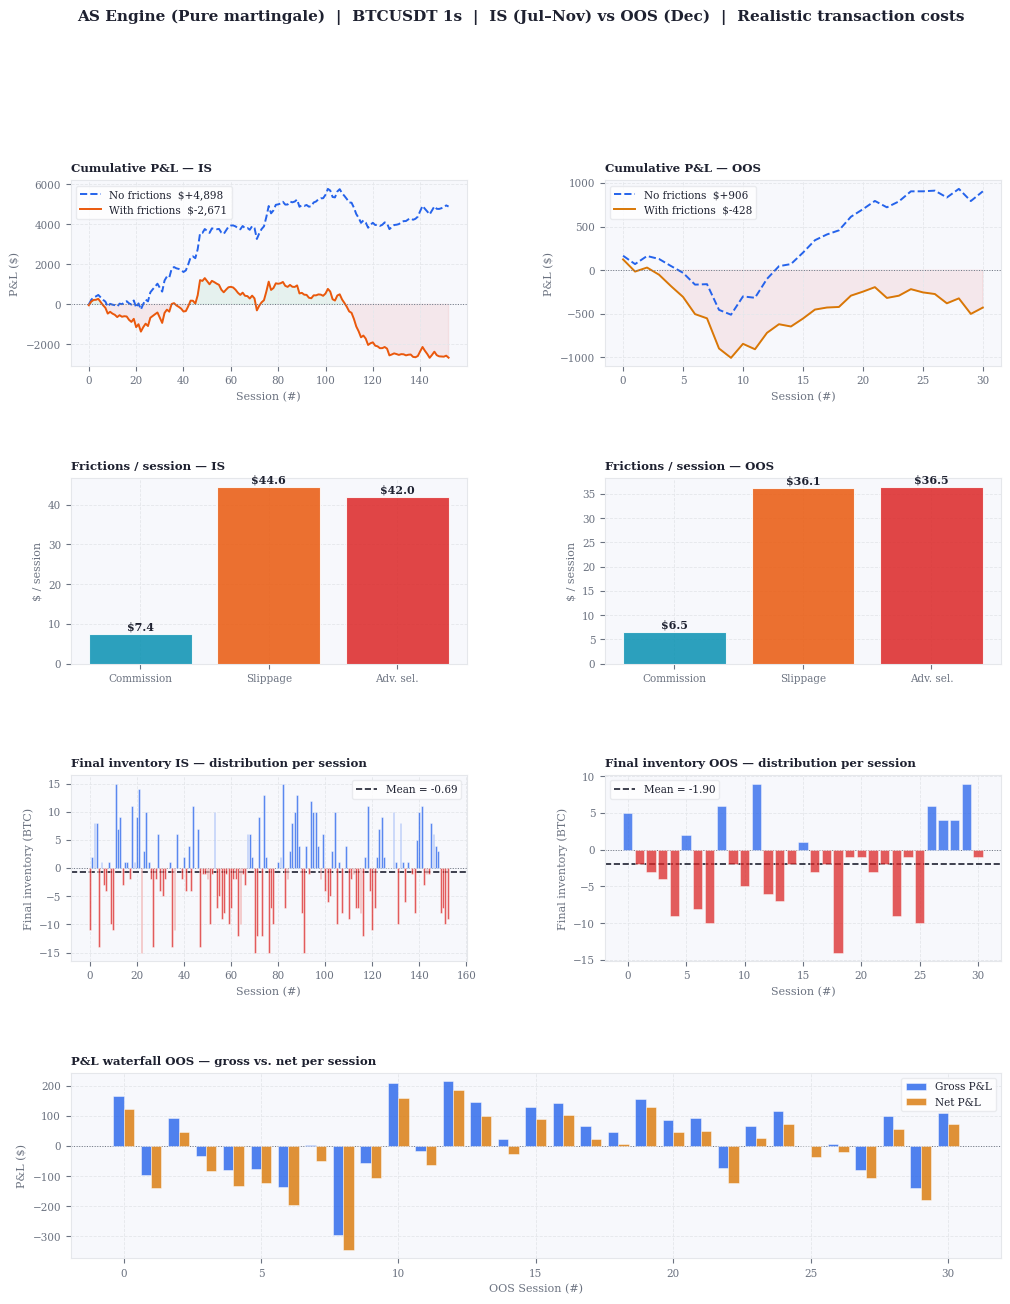

In [ ]:
# ══════════════════════════════════════════════════════════════════
# MAIN
# ══════════════════════════════════════════════════════════════════

def main():
    from pathlib import Path

    # Load and split data
    print('Loading data...')
    ROOT = Path('..').resolve()
    df   = pd.read_parquet(ROOT / 'data' / DATA_PATH)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['month'] = df['timestamp'].dt.month

    df_is  = df[df['month'].isin(IS_MONTHS)].copy()
    df_oos = df[df['month'].isin(OOS_MONTHS)].copy()

    print(f'IS  : {len(df_is):,} candles  '
          f'({df_is.timestamp.dt.date.nunique()} sessions)')
    print(f'OOS : {len(df_oos):,} candles  '
          f'({df_oos.timestamp.dt.date.nunique()} sessions)')

    # Calibrate on IS data only
    print('\n=== CALIBRATION (In-Sample) ===')
    ep = calibrate(df_is)

    # Zero-friction baseline and realistic frictions
    fp_zero = FrictionParams(lot_size=0.1, commission_per_share=0.0,
                             lag_min_sec=0.0, lag_max_sec=0.0, adv_sel_scale=0.0)
    fp_real = FrictionParams(lot_size=0.1, commission_per_share=0.02,
                             lag_min_sec=0.05, lag_max_sec=0.20, adv_sel_scale=0.1)

    # Run all four backtests
    print('\n=== BACKTESTS ===')
    _, ses_is_nf,  st_is_nf,  _          = run_backtest(df_is,  ep, fp_zero, 'IS  — no frictions',  RANDOM_SEED)
    _, ses_is_f,   st_is_f,   trades_is  = run_backtest(df_is,  ep, fp_real, 'IS  — with frictions', RANDOM_SEED)
    _, ses_oos_nf, st_oos_nf, _          = run_backtest(df_oos, ep, fp_zero, 'OOS — no frictions',  RANDOM_SEED)
    _, ses_oos_f,  st_oos_f,  trades_oos = run_backtest(df_oos, ep, fp_real, 'OOS — with frictions', RANDOM_SEED)

    # Export trade logs
    export_trade_logs(trades_is,  ses_is_f,  'results/logs_trades/as_engine/btc_is_trades_as.csv')
    export_trade_logs(trades_oos, ses_oos_f, 'results/logs_trades/as_engine/btc_oos_trades_as.csv')

    # Summary table
    print(f'\n{"═"*72}')
    print(f'{"Metric":<30} {"IS no-fric":>10} {"IS fric":>10} '
          f'{"OOS no-fric":>11} {"OOS fric":>10}')
    print('─' * 72)
    rows = [
        ('Total P&L ($)',
         st_is_nf['pnls'].sum(),   st_is_f['pnls'].sum(),
         st_oos_nf['pnls'].sum(),  st_oos_f['pnls'].sum()),
        ('Mean P&L/session ($)',
         st_is_nf['pnls'].mean(),  st_is_f['pnls'].mean(),
         st_oos_nf['pnls'].mean(), st_oos_f['pnls'].mean()),
        ('Annualised Sharpe',
         st_is_nf['sharpe'],  st_is_f['sharpe'],
         st_oos_nf['sharpe'], st_oos_f['sharpe']),
        ('Win rate (%)',
         (st_is_nf['pnls']>0).mean()*100,  (st_is_f['pnls']>0).mean()*100,
         (st_oos_nf['pnls']>0).mean()*100, (st_oos_f['pnls']>0).mean()*100),
        ('Max drawdown ($)',
         st_is_nf['dd'].min(),  st_is_f['dd'].min(),
         st_oos_nf['dd'].min(), st_oos_f['dd'].min()),
        ('Frictions/session ($)',
         0.0, st_is_f['ses']['total_friction'].mean(),
         0.0, st_oos_f['ses']['total_friction'].mean()),
    ]
    for name, a, b, c, d in rows:
        print(f'{name:<30} {a:>10.3f} {b:>10.3f} {c:>11.3f} {d:>10.3f}')

    # OOS friction breakdown
    print('\n=== OOS FRICTION BREAKDOWN ===')
    s   = st_oos_f['ses']
    tot = s['total_friction'].mean()
    for col, lbl in [('comm', 'Commission   '),
                     ('slippage', 'Slippage     '),
                     ('adv_sel', 'Adverse sel. ')]:
        v = s[col].mean()
        print(f'  {lbl} ${v:>8.2f}  ({v/tot*100:>5.1f}%)')
    print(f'  {"TOTAL        "} ${tot:>8.2f}')
    print(f'  Gross P&L/session  ${st_oos_nf["pnls"].mean():>8.2f}')
    print(f'  Net P&L/session    ${st_oos_f["pnls"].mean():>8.2f}')
    print(f'  Friction impact    '
          f'${st_oos_nf["pnls"].mean() - st_oos_f["pnls"].mean():>8.2f} '
          f'({(1 - st_oos_f["pnls"].mean()/st_oos_nf["pnls"].mean())*100:.1f}%)')

    # Plot
    plot_results(st_is_nf, st_is_f, st_oos_nf, st_oos_f,
                 ticker=ticker, model=model)


if __name__ == '__main__':
    main()